# Imports

In [1]:
import numpy as np
import os
import csv
import gensim
from sklearn.externals import joblib
import torch.nn.functional as F
import torch.nn as nn
import torch

In [2]:
# glove_data = 'glove.840B.300d.txt'
glove_data = 'glove.6B.300d.txt'
# words = pd.read_table(glove_data, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

In [ ]:
!ls *txt

# One Time Run 

In [4]:
# Store genism model for getting n similar words eventually
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_data, tmp_file)

In [5]:
model1 = KeyedVectors.load_word2vec_format(tmp_file)

In [6]:
filename = 'gensim.pkl'
joblib.dump(model1, filename)  

# # This gives memory error
# import pickle as pkl
# with open(os.getcwd()+'/gensim.pkl', 'wb') as f:
#     pkl.dump(model1, f, protocol=2)

['gensim.pkl']

In [ ]:
asdasd = [1,2,3,4,5,5,5,5,5,5,5,5,6,7,8,7]
asdasd[-4:]

In [7]:
#Store Glove word embeddings as dictionary
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    with open(gloveFile,'r', encoding="utf8") as f:
        model = {}
        for line in f:
            splitLine = line.split()
            word_end_index = len(splitLine) - 300 
            word = ' '.join(splitLine[0:word_end_index])
            embedding = np.array([float(val) for val in splitLine[-300:]])
            model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

In [8]:
model = loadGloveModel(glove_data)

Loading Glove Model
Done. 400000  words loaded!


In [9]:
filename = 'embeddings.pkl'
joblib.dump(model, filename)  

#following gives memory error:
# import pickle as pkl
# with open(os.getcwd()+'/embeddings.pkl', 'wb') as f:
#     pkl.dump(model, f)

['embeddings.pkl']

# Load gensim and Glove embedding

In [3]:
gensim_vec = joblib.load('gensim.pkl')

In [4]:
VECTORS = joblib.load('embeddings.pkl')

In [ ]:
# with open(os.getcwd()+'/gensim.pkl', 'rb') as f: #gensim helps in finding n similar words
#     gensim_vec = pkl.load(f)

In [ ]:
# with open(os.getcwd()+'/embeddings.pkl', 'rb') as f:
#     vec = pkl.load(f)

# Nearest words function 

In [5]:
def nearest_words(word, n):
    rel =[]
    rel_words = gensim_vec.similar_by_word(word, topn = n, restrict_vocab=None)
    [rel.append(w[0]) for w in rel_words]
    return rel    

# Near words test

In [13]:
rel = nearest_words('nurse', 10)
print(rel)

['nurses', 'nursing', 'doctor', 'physician', 'midwife', 'hospital', 'dentist', 'therapist', 'patient', 'practitioner']


# Similarity function

In [6]:
def cosine_similarity(x, y):
    if type(x) is str:
        x = VECTORS[x]
    if type(y) is str:
        y = VECTORS[y]
    cos = np.dot(x, y) / (np.linalg.norm(x)*np.linalg.norm(y))
    return cos

# Test

In [62]:
n = VECTORS['nurse']
d = VECTORS['death']
cosine_similarity(n ,d)

TypeError: matmul(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
cos = nn.CosineSimilarity(dim=0)
cos(torch.tensor(n), torch.tensor(d))

# Vector implementation

In [7]:
def get_X(nfeatures=1, datapoints=300, low=-1, high=1):
    return torch.FloatTensor(np.random.uniform(low, high, size=(datapoints)))

In [8]:
word = 'nurse'
old_vec = torch.FloatTensor(VECTORS[word]).requires_grad_(True)
X = get_X().requires_grad_(True)
near_vec = torch.FloatTensor([VECTORS[l] for l in nearest_words(word, 10)]).requires_grad_(True)
male_words = ['male', 'man', 'he', 'husband', 'boy']
female_words = ['female', 'woman', 'she', 'wife', 'girl']
male_vectors = torch.FloatTensor([VECTORS[word] for word in male_words]).requires_grad_(True)
female_vectors = torch.FloatTensor([VECTORS[word] for word in female_words]).requires_grad_(True)

In [9]:
def cosine_similarity(X, male_vectors):
    return torch.matmul(male_vectors, X) /  (male_vectors.norm(dim=1) * X.norm(dim=0))

def objective(X, old_vec, near_vec, male, female):
    male_similarity = cosine_similarity(X, male_vectors)
    female_similarity = cosine_similarity(X, female_vectors)
    G = torch.abs(male_similarity - female_similarity).mean(dim=0)
    new_vec_localization = cosine_similarity(X, near_vec)
    old_vec_localization = cosine_similarity(old_vec, near_vec)
    M = torch.abs(new_vec_localization - old_vec_localization).mean(dim=0)
    J = G + M
#     J = r * G + (1 - r) * M #Do later
    return J

In [ ]:
# t = objective(X, old_vec, near_vec, male_vectors, female_vectors)
# t.backward()

# 10zin insanity check (skip, this was to compare my vector implementation with 10zin's real implementation)

In [ ]:
def cosine_similarity_10zin(x, y):
    if type(x) is str:
        x = VECTORS[x]
    if type(y) is str:
        y = VECTORS[y]
    cos = np.dot(x, y) / (np.linalg.norm(x)*np.linalg.norm(y))
    return cos

def objective_fn(old_vec, new_vec, nearVec, gender, r):
    M = 0
    G = 0
#     gender = dictionary  with male as key and female as value for easy access
    
#     Bias eliminating function
    for male, female in gender.items():
        #diff b/w male and its female counterparts bias with vector
            
        G += abs( cosine_similarity_10zin(new_vec, male) - cosine_similarity_10zin(new_vec, female) )
        
    G = G/(len(gender)) #Average of gender bias 
    
    
#     Originality maintaining function
    for vec in nearVec:    
        #diff b/w new vector and old biased vector with respect to high proximity vectors of old vector
        M += abs( cosine_similarity_10zin(new_vec, vec) - cosine_similarity_10zin(old_vec, vec) ) 
        
    M = M/(len(nearVec)) #Average diff 
    print(f"Shape: {len(nearVec)}")
    
#     J = r*G + (1-r)*M
    J = G + M
    print(f"G: {G}")
    print(f"M: {M}")
    return J

new_vec = X.detach().numpy()
old = 'nurse'
r = 0.5
near_Vec = nearest_words('nurse', 10)# Get n nearest words, here n = 10
gender = {'male':'female','man':'woman','he':'she','husband':'wife','boy':'girl'}
print(objective_fn(old, new_vec, near_Vec , gender, r))

It's the same. Let's start working on minimizing now

# Gradient descent minimization

## GD from scratch (skip this)

In [ ]:
word = 'nurse'
old_vec = torch.FloatTensor(VECTORS[word]).requires_grad_(True)
X = get_X().requires_grad_(True)
near_vec = torch.FloatTensor([VECTORS[l] for l in nearest_words(word, 10)]).requires_grad_(True)
male_words = ['male', 'man', 'he', 'husband', 'boy']
female_words = ['female', 'woman', 'she', 'wife', 'girl']
male_vectors = torch.FloatTensor([VECTORS[word] for word in male_words]).requires_grad_(True)
female_vectors = torch.FloatTensor([VECTORS[word] for word in female_words]).requires_grad_(True)

In [ ]:
epoch = 5
alpha = 0.1
for e in range(epoch):
    out = objective(X, old_vec, near_vec, male_vectors, female_vectors)
    out.backward()
    print(X.grad)
    updatedX = X - alpha * X.grad
    print(f"Epoch: {e}")

In [ ]:
nn.Parameter?

## extend nn.module with adam optimizers

In [10]:
class myModel(nn.Module):
    def __init__(self, X, old_vec, near_vec, male_vectors, female_vectors):
        super(myModel, self).__init__()
        self.old_vec = old_vec
        self.near_vec = near_vec
        self.male_vectors = male_vectors
        self.female_vectors = female_vectors
        self.X = nn.Parameter(X)
        
    def forward(self):
        return  objective(self.X, self.old_vec, self.near_vec, self.male_vectors, self.female_vectors)

In [11]:
def minimize(lr, max_epochs, X, old_vec, near_vec, male_vectors, female_vectors):
    m = myModel(X, old_vec, near_vec, male_vectors, female_vectors)
    optimizer = torch.optim.Adam(m.parameters(), lr=lr)
    for epoch in range(max_epochs):
            optimizer.zero_grad()
            out = m.forward()
            out.backward()
            optimizer.step()
            print(f"Epoch: {epoch} | objective: {out}")
    return m.X        

In [12]:
lr = 1e-1
max_epochs = int(1e3)
word = 'nurse'
old_vec = torch.FloatTensor(VECTORS[word]).requires_grad_(True)
X = get_X().requires_grad_(True)
original_X = X.detach().clone()
near_vec = torch.FloatTensor([VECTORS[l] for l in nearest_words(word, 10)]).requires_grad_(True)
male_vectors = torch.FloatTensor([VECTORS[word] for word in  ['male', 'man', 'he', 'husband', 'boy']]).requires_grad_(True)
female_vectors = torch.FloatTensor([VECTORS[word] for word in ['female', 'woman', 'she', 'wife', 'girl']]).requires_grad_(True)

In [13]:
updatedX = minimize(lr, max_epochs, X, old_vec, near_vec, male_vectors, female_vectors)

Epoch: 0 | objective: 0.5398791432380676
Epoch: 1 | objective: 0.4421660304069519
Epoch: 2 | objective: 0.3760484457015991
Epoch: 3 | objective: 0.3038818836212158
Epoch: 4 | objective: 0.24024713039398193
Epoch: 5 | objective: 0.1840737760066986
Epoch: 6 | objective: 0.13746318221092224
Epoch: 7 | objective: 0.09952504932880402
Epoch: 8 | objective: 0.07358022034168243
Epoch: 9 | objective: 0.06312940269708633
Epoch: 10 | objective: 0.05910877883434296
Epoch: 11 | objective: 0.05651125684380531
Epoch: 12 | objective: 0.050603993237018585
Epoch: 13 | objective: 0.0434536375105381
Epoch: 14 | objective: 0.03909509629011154
Epoch: 15 | objective: 0.034733742475509644
Epoch: 16 | objective: 0.03021395578980446
Epoch: 17 | objective: 0.025473227724432945
Epoch: 18 | objective: 0.023729529231786728
Epoch: 19 | objective: 0.023043841123580933
Epoch: 20 | objective: 0.023805713281035423
Epoch: 21 | objective: 0.025868713855743408
Epoch: 22 | objective: 0.026641864329576492
Epoch: 23 | objecti

Epoch: 184 | objective: 0.0026974081993103027
Epoch: 185 | objective: 0.003224089741706848
Epoch: 186 | objective: 0.0022611855529248714
Epoch: 187 | objective: 0.002744123339653015
Epoch: 188 | objective: 0.0035160542465746403
Epoch: 189 | objective: 0.0022075443994253874
Epoch: 190 | objective: 0.002680104924365878
Epoch: 191 | objective: 0.0035779804456979036
Epoch: 192 | objective: 0.002095308853313327
Epoch: 193 | objective: 0.003296306822448969
Epoch: 194 | objective: 0.0034344405867159367
Epoch: 195 | objective: 0.0031332671642303467
Epoch: 196 | objective: 0.003422081470489502
Epoch: 197 | objective: 0.0029503880068659782
Epoch: 198 | objective: 0.0020263553597033024
Epoch: 199 | objective: 0.0015506534837186337
Epoch: 200 | objective: 0.0023220092989504337
Epoch: 201 | objective: 0.0024076015688478947
Epoch: 202 | objective: 0.0022733211517333984
Epoch: 203 | objective: 0.002317950129508972
Epoch: 204 | objective: 0.0017607032787054777
Epoch: 205 | objective: 0.002044293098151

Epoch: 368 | objective: 0.002814915729686618
Epoch: 369 | objective: 0.0019460737239569426
Epoch: 370 | objective: 0.002992522669956088
Epoch: 371 | objective: 0.0032088845036923885
Epoch: 372 | objective: 0.0027854950167238712
Epoch: 373 | objective: 0.0043033091351389885
Epoch: 374 | objective: 0.0031281441915780306
Epoch: 375 | objective: 0.0038137256633490324
Epoch: 376 | objective: 0.004115116782486439
Epoch: 377 | objective: 0.002616780810058117
Epoch: 378 | objective: 0.0041845738887786865
Epoch: 379 | objective: 0.005038377828896046
Epoch: 380 | objective: 0.003541296813637018
Epoch: 381 | objective: 0.0033354549668729305
Epoch: 382 | objective: 0.0040199607610702515
Epoch: 383 | objective: 0.00224876101128757
Epoch: 384 | objective: 0.004498767666518688
Epoch: 385 | objective: 0.005519497208297253
Epoch: 386 | objective: 0.0038707107305526733
Epoch: 387 | objective: 0.0035755871795117855
Epoch: 388 | objective: 0.005400490947067738
Epoch: 389 | objective: 0.0042951167561113834

Epoch: 549 | objective: 0.002132028341293335
Epoch: 550 | objective: 0.002207645680755377
Epoch: 551 | objective: 0.0028523027431219816
Epoch: 552 | objective: 0.002345332410186529
Epoch: 553 | objective: 0.0021484731696546078
Epoch: 554 | objective: 0.0019093274604529142
Epoch: 555 | objective: 0.0017700999742373824
Epoch: 556 | objective: 0.0019643991254270077
Epoch: 557 | objective: 0.001472723437473178
Epoch: 558 | objective: 0.0012653886806219816
Epoch: 559 | objective: 0.001958400011062622
Epoch: 560 | objective: 0.0017523437272757292
Epoch: 561 | objective: 0.0015922575257718563
Epoch: 562 | objective: 0.0014865815173834562
Epoch: 563 | objective: 0.002182659460231662
Epoch: 564 | objective: 0.0022436915896832943
Epoch: 565 | objective: 0.0019126415718346834
Epoch: 566 | objective: 0.0023509026505053043
Epoch: 567 | objective: 0.0029572010971605778
Epoch: 568 | objective: 0.0018756508361548185
Epoch: 569 | objective: 0.0025197328068315983
Epoch: 570 | objective: 0.00209113070741

Epoch: 730 | objective: 0.0036677629686892033
Epoch: 731 | objective: 0.0035720288287848234
Epoch: 732 | objective: 0.0030077516566962004
Epoch: 733 | objective: 0.003168955445289612
Epoch: 734 | objective: 0.0037731914781033993
Epoch: 735 | objective: 0.0030013560317456722
Epoch: 736 | objective: 0.0035294622648507357
Epoch: 737 | objective: 0.0032539248932152987
Epoch: 738 | objective: 0.002779260277748108
Epoch: 739 | objective: 0.0017561852000653744
Epoch: 740 | objective: 0.002227103803306818
Epoch: 741 | objective: 0.0020557523239403963
Epoch: 742 | objective: 0.0025808035861700773
Epoch: 743 | objective: 0.002098953817039728
Epoch: 744 | objective: 0.0024876773823052645
Epoch: 745 | objective: 0.001514878822490573
Epoch: 746 | objective: 0.0033511905930936337
Epoch: 747 | objective: 0.004202655050903559
Epoch: 748 | objective: 0.0025273114442825317
Epoch: 749 | objective: 0.0026035369373857975
Epoch: 750 | objective: 0.002915903925895691
Epoch: 751 | objective: 0.002691549248993

Epoch: 910 | objective: 0.003160017542541027
Epoch: 911 | objective: 0.002100852085277438
Epoch: 912 | objective: 0.0026832311414182186
Epoch: 913 | objective: 0.0025593042373657227
Epoch: 914 | objective: 0.0035457194317132235
Epoch: 915 | objective: 0.0029659331776201725
Epoch: 916 | objective: 0.0016293376684188843
Epoch: 917 | objective: 0.003728854702785611
Epoch: 918 | objective: 0.004141161218285561
Epoch: 919 | objective: 0.0025588541757315397
Epoch: 920 | objective: 0.0033686282113194466
Epoch: 921 | objective: 0.0034966678358614445
Epoch: 922 | objective: 0.0027300268411636353
Epoch: 923 | objective: 0.004720109514892101
Epoch: 924 | objective: 0.004384097643196583
Epoch: 925 | objective: 0.0023090243339538574
Epoch: 926 | objective: 0.0037768392357975245
Epoch: 927 | objective: 0.004232659935951233
Epoch: 928 | objective: 0.0029710887465626
Epoch: 929 | objective: 0.003498286008834839
Epoch: 930 | objective: 0.003055089619010687
Epoch: 931 | objective: 0.0028958707116544247


In [14]:
F.cosine_similarity(old_vec, updatedX, dim=0) #Check how close new vector is to old one, shouldn't be too close, shouldn't be too far

tensor(0.6991, grad_fn=<DivBackward1>)

In [15]:
he = torch.FloatTensor(VECTORS['he'])
she = torch.FloatTensor(VECTORS['she'])
F.cosine_similarity(old_vec, he, dim=0)

tensor(0.1747, grad_fn=<DivBackward1>)

In [16]:
F.cosine_similarity(old_vec, she, dim=0)

tensor(0.3621, grad_fn=<DivBackward1>)

In [17]:
F.cosine_similarity(updatedX, he, dim=0)

tensor(0.2039, grad_fn=<DivBackward1>)

In [18]:
F.cosine_similarity(updatedX, she, dim=0)

tensor(0.2057, grad_fn=<DivBackward1>)

In [85]:
he = torch.FloatTensor(VECTORS['patient'])

In [86]:
F.cosine_similarity(updatedX, he,  dim=0)

tensor(0.5172, grad_fn=<DivBackward1>)

In [ ]:
# m = myModel(X, old_vec, near_vec, male_vectors, female_vectors)
# optimizer = torch.optim.Adam(m.parameters(), lr=lr)
# for epoch in range(5):
#         optimizer.zero_grad()
#         out = m.forward()
#         out.backward()
#         optimizer.step()
#         print(f"Epoch: {epoch} | objective: {out}")
#         print(m.X,'\n\n\n\n')

# Visualize embeddings
## 10zin krde ye please

# PCA

[0.80509791 0.06291439 0.04720846]
[28.14288812  7.86718376  6.81481781]


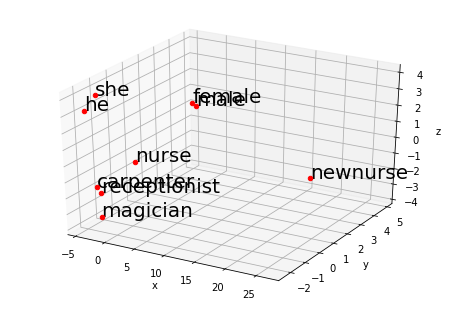

In [55]:
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

words = ['he', 'she','male', 'female', 'carpenter', 'magician', 'nurse', 'receptionist']
v = []
for w in words:
    v.append(VECTORS[w])
words.append('newnurse')
# words.append('genderDirect')
v.append(updatedX.detach().numpy())
# v.append(x)
pca = PCA(n_components=3)
vec3d = pca.fit_transform(v)

# plt.plot(sklearn_transf[0:20,0],sklearn_transf[0:20,1], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
# plt.plot(sklearn_transf[20:40,0], sklearn_transf[20:40,1], '^', markersize=7, color='red', alpha=0.5, label='class2')

# plt.xlabel('x_values')
# plt.ylabel('y_values')
# plt.xlim([-4,4])
# plt.ylim([-4,4])
# plt.legend()
# plt.title('Transformed samples with class labels from matplotlib.mlab.PCA()')

# plt.show()

print(pca.explained_variance_ratio_)
print(pca.singular_values_) 

fig = plt.figure()
ax = Axes3D(fig)
    
for point, word in zip(vec3d, words):
        # plot points
        ax.scatter(point[0],point[1],point[2], c = 'r')
        # plot word annotations
        ax.text(point[0],point[1],point[2],'%s' % (word), size=20, zorder=1, color='k') 

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [26]:
def _np_normalize(v):
  """Returns the input vector, normalized."""
  return v / np.linalg.norm(v)

In [27]:
def find_gender_direction(VECTOR):
  """Finds and returns a 'gender direction'."""
  pairs = [
      ("woman", "man"),
      ("her", "his"),
      ("she", "he"),
      ("aunt", "uncle"),
      ("niece", "nephew"),
      ("daughters", "sons"),
      ("mother", "father"),
      ("daughter", "son"),
      ("granddaughter", "grandson"),
      ("girl", "boy"),
      ("stepdaughter", "stepson"),
      ("mom", "dad"),
  ]
  m = []
  for wf, wm in pairs:
    m.append(VECTOR[wf] - VECTOR[wm])

  # the next three lines are just a PCA.
  m = np.cov(np.array(m).T)
  evals, evecs = np.linalg.eig(m)
  return _np_normalize(np.real(evecs[:, np.argmax(evals)]))

In [51]:
x = find_gender_direction(VECTORS)

In [138]:
x = torch.FloatTensor(x)

In [150]:
cosine_similarity(VECTORS[''], x)

0.00835571006577101

In [57]:
def projection(x, y):#projectionof x on y
    return (np.dot(x, y)/np.linalg.norm(y)**2)* y

[1.00000000e+00 2.20436049e-32 7.63188001e-33]
[1.07491072e+00 1.59592951e-16 9.39048801e-17]


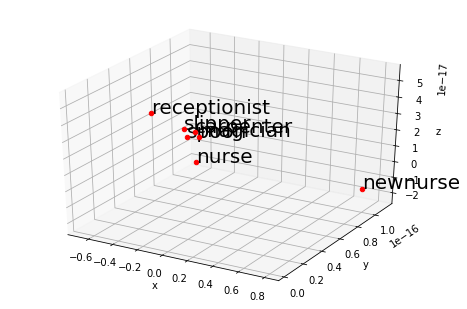

In [60]:
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

words = ['carpenter', 'magician', 'nurse', 'receptionist', 'spoon', 'slipper']
v = []
for w in words:
    v.append(VECTORS[w])
words.append('newnurse')
# words.append('genderDirect')
v.append(updatedX.detach().numpy())
proj = []
for a in v:
    proj.append(projection(a, x))
# v.append(x)
pca = PCA(n_components=3)
vec3d = pca.fit_transform(proj)

# plt.plot(sklearn_transf[0:20,0],sklearn_transf[0:20,1], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
# plt.plot(sklearn_transf[20:40,0], sklearn_transf[20:40,1], '^', markersize=7, color='red', alpha=0.5, label='class2')

# plt.xlabel('x_values')
# plt.ylabel('y_values')
# plt.xlim([-4,4])
# plt.ylim([-4,4])
# plt.legend()
# plt.title('Transformed samples with class labels from matplotlib.mlab.PCA()')

# plt.show()

print(pca.explained_variance_ratio_)
print(pca.singular_values_) 

fig = plt.figure()
ax = Axes3D(fig)
    
for point, word in zip(vec3d, words):
        # plot points
        ax.scatter(point[0],point[1],point[2], c = 'r')
        # plot word annotations
        ax.text(point[0],point[1],point[2],'%s' % (word), size=20, zorder=1, color='k') 

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_zlabel('z')
plt.show()

# PLotting via similarity diff

In [186]:
male = ['president', 'philosopher', 'broadcaster']
female = ['babysitter', 'receptionist', 'nurse']
neutral = ['spoon', 'slipper', 'desk']
pairs = [
      ("woman", "man"),
      ("her", "his"),
      ("she", "he"),
      ("aunt", "uncle"),
      ("niece", "nephew"),
      ("daughters", "sons"),
      ("mother", "father"),
      ("daughter", "son"),
      ("granddaughter", "grandson"),
      ("girl", "boy"),
      ("stepdaughter", "stepson"),
      ("mom", "dad"),
  ]


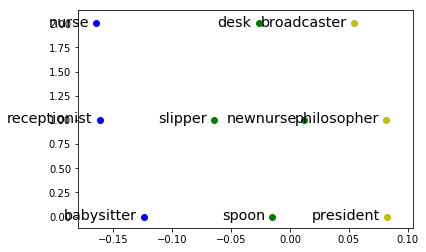

In [201]:
plt.figure()
biasm= []
biasf = []
biasn= []
for m, f, n in zip(male, female, neutral):
    diffm = 0
    difff = 0
    diffn = 0
    for wf, wm in pairs:
        diffm = diffm + cosine_similarity(VECTORS[m], wm) - cosine_similarity(VECTORS[m], wf)
        difff = difff + cosine_similarity(VECTORS[f], wm) - cosine_similarity(VECTORS[f], wf)
        diffn = diffn + cosine_similarity(VECTORS[n], wm) - cosine_similarity(VECTORS[n], wf)
    diffm = diffm/len(pairs)
    difff = difff/len(pairs)
    diffn = diffn/len(pairs)
    biasm.append(diffm)
    biasf.append(difff)
    biasn.append(diffn)

def annotate(x, y, word, plt):
    plt.annotate(
            word, 
            xy=(x, y),
            xytext=(-7, -6) if first else (7, -6),
            textcoords='offset points',
            ha='right' if first else 'left',
            va='bottom',
            size="x-large"
        )

for i, point in enumerate(zip(biasm, male, biasf, female, biasn, neutral)):
        
        # plot points

        plt.scatter(point[0], i, c = 'y')
        plt.scatter(point[2], i, c = 'b')
        plt.scatter(point[4], i, c = 'g')
        
        # plot word annotations
        
        annotate(point[0], i, point[1], plt)
        annotate(point[2], i, point[3], plt)
        annotate(point[4], i, point[5], plt)

for m, f, n in zip(male, female, neutral):
    diffupdate = 0
    diffupdate = diffupdate + cosine_similarity(x, wf) - cosine_similarity(x, wm)
diffupdate = diffupdate/len(pairs)
plt.scatter(diffupdate, 1, c = 'g')
annotate(diffupdate, 1, 'newnurse', plt)
plt.show()

# ROUGH

# Plotting via gender direction(fail attempt)

In [195]:
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

words = ['watch', 'nurse', 'spoon','broadcaster']
v = []
for w in words:
    v.append(VECTORS[w])
words.append('newnurse')
# words.append('genderDirect')
v.append(updatedX.detach().numpy())
proj = []
for a in v:
    proj.append(projection(a, x))
# v.append(x)
pca = PCA(n_components=2)
vec2d = pca.fit_transform(proj)

# plt.plot(sklearn_transf[0:20,0],sklearn_transf[0:20,1], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
# plt.plot(sklearn_transf[20:40,0], sklearn_transf[20:40,1], '^', markersize=7, color='red', alpha=0.5, label='class2')

# plt.xlabel('x_values')
# plt.ylabel('y_values')
# plt.xlim([-4,4])
# plt.ylim([-4,4])
# plt.legend()
# plt.title('Transformed samples with class labels from matplotlib.mlab.PCA()')

# plt.show()

print(pca.explained_variance_ratio_)
print(pca.singular_values_) 

fig = plt.figure()

first = True # color alternation to divide given groups
for point, word in zip(vec2d, words):
        # plot points
        plt.scatter(point[0],point[1], c = 'r')
        # plot word annotations
        plt.annotate(
            word, 
            xy=(point[0], point[1]),
            xytext=(-7, -6) if first else (7, -6),
            textcoords='offset points',
            ha='right' if first else 'left',
            va='bottom',
            size="x-large"
        )


plt.show()

ValueError: only one element tensors can be converted to Python scalars

In [136]:
cosine_similarity(VECTORS['she'], VECTORS['librarian'])

0.2279383401557658

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import pickle as pkl

In [65]:
 with open(r'C:\Users\pasan\Documents\DebiasingEmbeddings\embeddings.pkl', 'rb') as f:
    vec = pkl.load(f)

In [64]:
def pca(words, vectors):

    pca = PCA(n_components=2, whiten=True)
    vectors2d = pca.fit(vectors).transform(vectors)

    plt.figure(figsize=(10, 10))
    plt.axis([-5, 5, -5, 5])


    first = True  # color alternation to divide given groups
    for point, word in zip(vectors2d, words):
        # plot points
        plt.scatter(point[0], point[1], c='r')
        # plot word annotations
        plt.annotate(
            word, 
            xy=(point[0], point[1]),
            xytext=(-7, -6) if first else (7, -6),
            textcoords='offset points',
            ha='right' if first else 'left',
            va='bottom',
            size="x-large"
        )

['newnurse', 'oldnurse', 'nurses', 'nursing', 'doctor', 'mechanic', 'he', 'she']


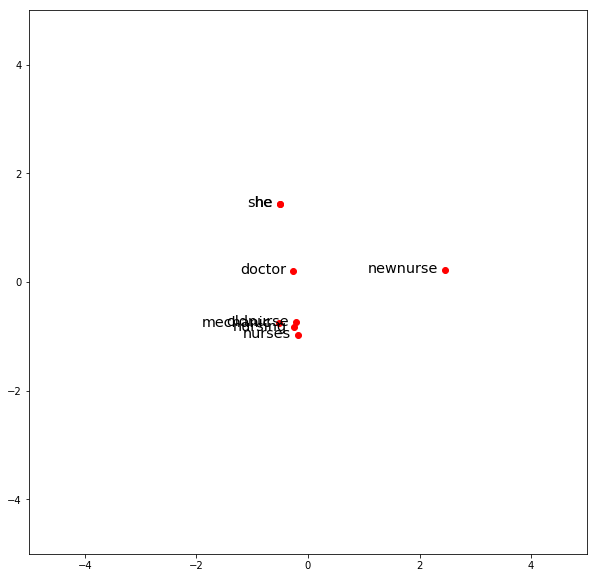

In [67]:
# word = ['carpenter', 'doctor', 'mechanic','nurse','secretary', 'babysitter','she', 'he', 'male','female']
words = ['newnurse', 'oldnurse', 'nurses', 'nursing', 'doctor', 'mechanic', 'he','she']
print(words)
vectors = []
vectors.append(updatedX.detach().numpy())
vectors.append(old_vec.detach().numpy())
vectors.append(VECTORS['nurses'])
vectors.append(VECTORS['nursing'])
vectors.append(VECTORS['doctor'])
vectors.append(VECTORS['mechanic'])
vectors.append(VECTORS['he'])
vectors.append(VECTORS['she'])

# print(updatedX.detach().numpy(), old_vec.detach().numpy())
# vectors = [vec[word] for word in words]
pca(words, vectors)